<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/6_BatchNormalization_Regularization/Experiments/BatchNorm/BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import StepLR,OneCycleLR

In [ ]:
class Net(nn.Module):
    def __init__(self,norm_type='BN',dropout_value = 0.01):
        super(Net, self).__init__()
        self.conv1 = self.conv2d(1, 8, 3,norm_type,dropout_value,2)
        self.conv2 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        
        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), #  Input 24x24 output 12x12 RF : 6x6
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  # Input 12x12 output 12x12 RF : 6x6
        )
        
        self.conv3 = self.conv2d(8, 16, 3,norm_type,dropout_value,4) 
        self.conv4 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.conv5 = self.conv2d(16, 16, 3,norm_type,dropout_value,4) 
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)
        self.conv6 =  self.conv2d(16, 16, 1,norm_type,dropout_value,4) 
        self.conv7 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False) 

    def conv2d(self, in_channels, out_channels, kernel_size, norm_type, dropout,num_of_groups):
        if norm_type == "BN":
         conv = nn.Sequential(OrderedDict([
                ('conv2d', nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('BatchNorm',nn.BatchNorm2d(out_channels)),
                ('Dropout', nn.Dropout(dropout))
         ]))
        elif norm_type == "LN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ## When number of groups is 1, its layernorm
                ('LayerNorm',nn.GroupNorm(1,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        elif norm_type == "GN":
            conv = nn.Sequential(OrderedDict([
                ('conv2d',nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False)),
                ('Relu', nn.ReLU()),
                ('GroupNorm',nn.GroupNorm(num_of_groups,out_channels)),
                ('Dropout',nn.Dropout(dropout))
            ]))
        else:
            conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=0, bias=False),
                nn.ReLU(),
                nn.Dropout(dropout)
            )
      
        return conv

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.avgpool2d(x)
        x = self.conv6(x)
        x = self.conv7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net('BN',0.01).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),                
                                       transforms.RandomAffine(degrees=7, shear=7, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
#train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
#test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,train_acc,train_loss,lambda_l1,scheduler):

  model.train()
  pbar = tqdm(train_loader)
  
  correct = 0
  processed = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1

    train_loss.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

    


In [ ]:

def test(model, device, test_loader,test_acc,test_losses):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))




In [ ]:
def experiments(train_loader, test_loader, norm_type, l1_factor, l2_factor, dropout, epochs, batchSize):
    
    train_losses = []
    test_losses = []
    train_accuracy = []
    test_accuracy = []
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
  
    network = Network()
    dataloader_args = dict(shuffle=True, batch_size=batchSize, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
    train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
    test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
    model = Net(norm_type, dropout).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.7,,weight_decay=l2_factor)
    scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=epochs,steps_per_epoch=len(train_loader))
    epochs = epochs

    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}:')
      train(model, device, train_loader, optimizer, epoch, train_accuracy, train_losses, l1_factor,scheduler)
      test(model, device, test_loader,test_accuracy,test_losses)

    return (train_accuracy,train_losses,test_accuracy,test_losses),model

In [ ]:
exp = {  
    'BatchNorm':[]
    'BatchNorm+L1':['BN',0.002,0]
}
parameters = dict(
    batch_size = [64,128]
    ,l1 = [0, .001, .002]
    ,l2 = [0, .001, .002]
)

param_values = [v for v in parameters.values()]

for batch_size, l1, l2 in product(*param_values): 
  exp_metrics = {}
  print('\n' +'\033[1m' + '=====================================Model Training for batch size:  ' + batch_size + ',l1:  '+ l1 + ',l2: '+l2 +'======================================================'+'\033[0m\n')
  (exp_metrics['BN']),model = experiments(train_loader, test_loader,'BN',l1,l2,0.03,20,batch_size)
  torch.save(model, './{}.pt'.format(e[0]))

'''for e in exp.items():
  print('\n' +'\033[1m' + '=====================================Model Training for '+ f'{e[0]} ======================================================'+'\033[0m\n')
  (exp_metrics[e[0]]),model = experiments(train_loader, test_loader,'BN',e[1][1],e[1][2],0.03,20)
  torch.save(model, './{}.pt'.format(e[0]))'''



  0%|          | 0/469 [00:00<?, ?it/s]


=====================================Model Training for BatchNorm+L1 ======================================================

Epoch 1:




Loss=3.5597901344299316 Batch_id=0 Accuracy=7.03:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=3.5597901344299316 Batch_id=0 Accuracy=7.03:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=3.52132511138916 Batch_id=1 Accuracy=7.42:   0%|          | 1/469 [00:00<02:15,  3.44it/s]  

Loss=3.3978633880615234 Batch_id=2 Accuracy=9.11:   0%|          | 1/469 [00:00<02:15,  3.44it/s]

Loss=3.3978633880615234 Batch_id=2 Accuracy=9.11:   1%|          | 3/469 [00:00<01:48,  4.28it/s]

Loss=3.427797317504883 Batch_id=3 Accuracy=8.79:   1%|          | 3/469 [00:00<01:48,  4.28it/s] 

Loss=3.4474830627441406 Batch_id=4 Accuracy=9.38:   1%|          | 3/469 [00:00<01:48,  4.28it/s]

Loss=3.4474830627441406 Batch_id=4 Accuracy=9.38:   1%|          | 5/469 [00:00<01:31,  5.06it/s]

Loss=3.409867286682129 Batch_id=5 Accuracy=9.64:   1%|          | 5/469 [00:00<01:31,  5.06it/s] 

Loss=3.427863597869873 Batch_id=6 Accuracy=9.60:   1%|          | 5/469 [00:00<01:31,  5.06it/s]

Loss=3.4278635978


Test set: Average loss: 0.2566, Accuracy: 9599/10000 (95.99%)

Epoch 2:




Loss=1.316152811050415 Batch_id=0 Accuracy=86.72:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=1.316152811050415 Batch_id=0 Accuracy=86.72:   0%|          | 1/469 [00:00<02:21,  3.31it/s]

Loss=1.315909504890442 Batch_id=1 Accuracy=87.89:   0%|          | 1/469 [00:00<02:21,  3.31it/s]

Loss=1.2615278959274292 Batch_id=2 Accuracy=88.54:   0%|          | 1/469 [00:00<02:21,  3.31it/s]

Loss=1.2615278959274292 Batch_id=2 Accuracy=88.54:   1%|          | 3/469 [00:00<01:50,  4.23it/s]

Loss=1.2815251350402832 Batch_id=3 Accuracy=89.06:   1%|          | 3/469 [00:00<01:50,  4.23it/s]

Loss=1.2734177112579346 Batch_id=4 Accuracy=89.53:   1%|          | 3/469 [00:00<01:50,  4.23it/s]

Loss=1.2734177112579346 Batch_id=4 Accuracy=89.53:   1%|          | 5/469 [00:00<01:33,  4.98it/s]

Loss=1.2911098003387451 Batch_id=5 Accuracy=89.71:   1%|          | 5/469 [00:00<01:33,  4.98it/s]

Loss=1.2911098003387451 Batch_id=5 Accuracy=89.71:   1%|▏         | 6/469 [00:00<01:21,  5.70it/s]

Loss=1.33


Test set: Average loss: 0.0777, Accuracy: 9798/10000 (97.98%)

Epoch 3:




Loss=0.8537740707397461 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.8537740707397461 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<02:36,  2.99it/s]

Loss=0.8781306147575378 Batch_id=1 Accuracy=91.41:   0%|          | 1/469 [00:00<02:36,  2.99it/s]

Loss=0.7785419225692749 Batch_id=2 Accuracy=93.23:   0%|          | 1/469 [00:00<02:36,  2.99it/s]

Loss=0.7785419225692749 Batch_id=2 Accuracy=93.23:   1%|          | 3/469 [00:00<02:03,  3.77it/s]

Loss=0.8747525215148926 Batch_id=3 Accuracy=92.97:   1%|          | 3/469 [00:00<02:03,  3.77it/s]

Loss=0.8085227012634277 Batch_id=4 Accuracy=93.12:   1%|          | 3/469 [00:00<02:03,  3.77it/s]

Loss=0.8085227012634277 Batch_id=4 Accuracy=93.12:   1%|          | 5/469 [00:00<01:42,  4.51it/s]

Loss=0.8030180931091309 Batch_id=5 Accuracy=93.62:   1%|          | 5/469 [00:00<01:42,  4.51it/s]

Loss=0.8297748565673828 Batch_id=6 Accuracy=93.86:   1%|          | 5/469 [00:00<01:42,  4.51it/s]

Loss=0


Test set: Average loss: 0.1013, Accuracy: 9689/10000 (96.89%)

Epoch 4:




Loss=0.7913707494735718 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.7913707494735718 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.6575733423233032 Batch_id=1 Accuracy=95.31:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.6161253452301025 Batch_id=2 Accuracy=96.35:   0%|          | 1/469 [00:00<02:25,  3.22it/s]

Loss=0.6161253452301025 Batch_id=2 Accuracy=96.35:   1%|          | 3/469 [00:00<01:55,  4.03it/s]

Loss=0.746292769908905 Batch_id=3 Accuracy=95.12:   1%|          | 3/469 [00:00<01:55,  4.03it/s] 

Loss=0.6650838255882263 Batch_id=4 Accuracy=95.00:   1%|          | 3/469 [00:00<01:55,  4.03it/s]

Loss=0.6650838255882263 Batch_id=4 Accuracy=95.00:   1%|          | 5/469 [00:00<01:40,  4.63it/s]

Loss=0.6773349046707153 Batch_id=5 Accuracy=95.18:   1%|          | 5/469 [00:00<01:40,  4.63it/s]

Loss=0.7550879716873169 Batch_id=6 Accuracy=95.09:   1%|          | 5/469 [00:01<01:40,  4.63it/s]

Loss=0


Test set: Average loss: 0.0983, Accuracy: 9699/10000 (96.99%)

Epoch 5:




Loss=0.6409856081008911 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.6409856081008911 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.7467816472053528 Batch_id=1 Accuracy=93.75:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.7909092903137207 Batch_id=2 Accuracy=93.49:   0%|          | 1/469 [00:00<02:31,  3.09it/s]

Loss=0.7909092903137207 Batch_id=2 Accuracy=93.49:   1%|          | 3/469 [00:00<02:01,  3.83it/s]

Loss=0.6341752409934998 Batch_id=3 Accuracy=93.95:   1%|          | 3/469 [00:00<02:01,  3.83it/s]

Loss=0.7255722284317017 Batch_id=4 Accuracy=93.59:   1%|          | 3/469 [00:00<02:01,  3.83it/s]

Loss=0.7255722284317017 Batch_id=4 Accuracy=93.59:   1%|          | 5/469 [00:00<01:41,  4.56it/s]

Loss=0.6333509087562561 Batch_id=5 Accuracy=94.01:   1%|          | 5/469 [00:00<01:41,  4.56it/s]

Loss=0.6038612723350525 Batch_id=6 Accuracy=94.53:   1%|          | 5/469 [00:01<01:41,  4.56it/s]

Loss=0


Test set: Average loss: 0.0872, Accuracy: 9717/10000 (97.17%)

Epoch 6:




Loss=0.6999205350875854 Batch_id=0 Accuracy=92.19:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.6999205350875854 Batch_id=0 Accuracy=92.19:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.6592937111854553 Batch_id=1 Accuracy=94.14:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.5831605792045593 Batch_id=2 Accuracy=95.57:   0%|          | 1/469 [00:00<02:35,  3.01it/s]

Loss=0.5831605792045593 Batch_id=2 Accuracy=95.57:   1%|          | 3/469 [00:00<02:07,  3.66it/s]

Loss=0.6272204518318176 Batch_id=3 Accuracy=95.70:   1%|          | 3/469 [00:00<02:07,  3.66it/s]

Loss=0.6841162443161011 Batch_id=4 Accuracy=95.16:   1%|          | 3/469 [00:00<02:07,  3.66it/s]

Loss=0.6841162443161011 Batch_id=4 Accuracy=95.16:   1%|          | 5/469 [00:00<01:47,  4.31it/s]

Loss=0.6013830304145813 Batch_id=5 Accuracy=95.44:   1%|          | 5/469 [00:00<01:47,  4.31it/s]

Loss=0.6362060904502869 Batch_id=6 Accuracy=95.65:   1%|          | 5/469 [00:01<01:47,  4.31it/s]

Loss=0


Test set: Average loss: 0.0833, Accuracy: 9744/10000 (97.44%)

Epoch 7:




Loss=0.6023983955383301 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.6023983955383301 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:32,  3.08it/s]

Loss=0.583659291267395 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<02:32,  3.08it/s] 

Loss=0.6121581792831421 Batch_id=2 Accuracy=96.88:   0%|          | 1/469 [00:00<02:32,  3.08it/s]

Loss=0.6121581792831421 Batch_id=2 Accuracy=96.88:   1%|          | 3/469 [00:00<02:04,  3.75it/s]

Loss=0.6189427971839905 Batch_id=3 Accuracy=96.29:   1%|          | 3/469 [00:00<02:04,  3.75it/s]

Loss=0.594738781452179 Batch_id=4 Accuracy=96.41:   1%|          | 3/469 [00:00<02:04,  3.75it/s] 

Loss=0.594738781452179 Batch_id=4 Accuracy=96.41:   1%|          | 5/469 [00:00<01:45,  4.39it/s]

Loss=0.6655579805374146 Batch_id=5 Accuracy=95.96:   1%|          | 5/469 [00:00<01:45,  4.39it/s]

Loss=0.6885377764701843 Batch_id=6 Accuracy=95.76:   1%|          | 5/469 [00:01<01:45,  4.39it/s]

Loss=0.


Test set: Average loss: 0.0678, Accuracy: 9807/10000 (98.07%)

Epoch 8:




Loss=0.6811372637748718 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.6811372637748718 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:27,  3.17it/s]

Loss=0.6994690895080566 Batch_id=1 Accuracy=94.14:   0%|          | 1/469 [00:00<02:27,  3.17it/s]

Loss=0.5848355293273926 Batch_id=2 Accuracy=94.79:   0%|          | 1/469 [00:00<02:27,  3.17it/s]

Loss=0.5848355293273926 Batch_id=2 Accuracy=94.79:   1%|          | 3/469 [00:00<02:00,  3.86it/s]

Loss=0.69231116771698 Batch_id=3 Accuracy=94.53:   1%|          | 3/469 [00:00<02:00,  3.86it/s]  

Loss=0.6602457761764526 Batch_id=4 Accuracy=94.53:   1%|          | 3/469 [00:00<02:00,  3.86it/s]

Loss=0.6602457761764526 Batch_id=4 Accuracy=94.53:   1%|          | 5/469 [00:00<01:42,  4.55it/s]

Loss=0.6573183536529541 Batch_id=5 Accuracy=94.27:   1%|          | 5/469 [00:00<01:42,  4.55it/s]

Loss=0.6573183536529541 Batch_id=5 Accuracy=94.27:   1%|▏         | 6/469 [00:00<01:25,  5.39it/s]

Loss=0


Test set: Average loss: 0.0760, Accuracy: 9761/10000 (97.61%)

Epoch 9:




Loss=0.5404030680656433 Batch_id=0 Accuracy=96.09:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.5404030680656433 Batch_id=0 Accuracy=96.09:   0%|          | 1/469 [00:00<02:42,  2.88it/s]

Loss=0.6113557815551758 Batch_id=1 Accuracy=94.53:   0%|          | 1/469 [00:00<02:42,  2.88it/s]

Loss=0.6575251817703247 Batch_id=2 Accuracy=94.27:   0%|          | 1/469 [00:00<02:42,  2.88it/s]

Loss=0.6575251817703247 Batch_id=2 Accuracy=94.27:   1%|          | 3/469 [00:00<02:08,  3.63it/s]

Loss=0.6522436141967773 Batch_id=3 Accuracy=93.95:   1%|          | 3/469 [00:00<02:08,  3.63it/s]

Loss=0.6522436141967773 Batch_id=3 Accuracy=93.95:   1%|          | 4/469 [00:00<01:46,  4.37it/s]

Loss=0.5711139440536499 Batch_id=4 Accuracy=94.22:   1%|          | 4/469 [00:00<01:46,  4.37it/s]

Loss=0.5711139440536499 Batch_id=4 Accuracy=94.22:   1%|          | 5/469 [00:00<01:44,  4.45it/s]

Loss=0.5197239518165588 Batch_id=5 Accuracy=94.79:   1%|          | 5/469 [00:00<01:44,  4.45it/s]

Loss=0


Test set: Average loss: 0.1961, Accuracy: 9435/10000 (94.35%)

Epoch 10:




Loss=0.7552753686904907 Batch_id=0 Accuracy=89.84:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.7552753686904907 Batch_id=0 Accuracy=89.84:   0%|          | 1/469 [00:00<02:39,  2.94it/s]

Loss=0.5697984099388123 Batch_id=1 Accuracy=92.97:   0%|          | 1/469 [00:00<02:39,  2.94it/s]

Loss=0.5697984099388123 Batch_id=1 Accuracy=92.97:   0%|          | 2/469 [00:00<02:05,  3.71it/s]

Loss=0.5874338746070862 Batch_id=2 Accuracy=93.49:   0%|          | 2/469 [00:00<02:05,  3.71it/s]

Loss=0.5874338746070862 Batch_id=2 Accuracy=93.49:   1%|          | 3/469 [00:00<01:53,  4.10it/s]

Loss=0.582679808139801 Batch_id=3 Accuracy=93.95:   1%|          | 3/469 [00:00<01:53,  4.10it/s] 

Loss=0.651278018951416 Batch_id=4 Accuracy=93.44:   1%|          | 3/469 [00:00<01:53,  4.10it/s]

Loss=0.651278018951416 Batch_id=4 Accuracy=93.44:   1%|          | 5/469 [00:00<01:40,  4.61it/s]

Loss=0.7328492403030396 Batch_id=5 Accuracy=93.10:   1%|          | 5/469 [00:01<01:40,  4.61it/s]

Loss=0.4


Test set: Average loss: 0.1584, Accuracy: 9491/10000 (94.91%)

Epoch 11:




Loss=0.5299555659294128 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.5299555659294128 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<02:34,  3.03it/s]

Loss=0.4982857406139374 Batch_id=1 Accuracy=94.92:   0%|          | 1/469 [00:00<02:34,  3.03it/s]

Loss=0.5784311294555664 Batch_id=2 Accuracy=94.79:   0%|          | 1/469 [00:00<02:34,  3.03it/s]

Loss=0.5784311294555664 Batch_id=2 Accuracy=94.79:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.5261873006820679 Batch_id=3 Accuracy=95.12:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.48880285024642944 Batch_id=4 Accuracy=95.47:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.48880285024642944 Batch_id=4 Accuracy=95.47:   1%|          | 5/469 [00:00<01:49,  4.25it/s]

Loss=0.5530776977539062 Batch_id=5 Accuracy=95.44:   1%|          | 5/469 [00:00<01:49,  4.25it/s] 

Loss=0.5048755407333374 Batch_id=6 Accuracy=95.76:   1%|          | 5/469 [00:01<01:49,  4.25it/s]

Los


Test set: Average loss: 0.1983, Accuracy: 9342/10000 (93.42%)

Epoch 12:




Loss=0.46462389826774597 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.46462389826774597 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<02:37,  2.97it/s]

Loss=0.5962005853652954 Batch_id=1 Accuracy=96.09:   0%|          | 1/469 [00:00<02:37,  2.97it/s] 

Loss=0.5899598598480225 Batch_id=2 Accuracy=96.09:   0%|          | 1/469 [00:00<02:37,  2.97it/s]

Loss=0.5899598598480225 Batch_id=2 Accuracy=96.09:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.5266950130462646 Batch_id=3 Accuracy=96.29:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.5033134818077087 Batch_id=4 Accuracy=96.41:   1%|          | 3/469 [00:00<02:11,  3.54it/s]

Loss=0.5033134818077087 Batch_id=4 Accuracy=96.41:   1%|          | 5/469 [00:00<01:49,  4.22it/s]

Loss=0.5876414775848389 Batch_id=5 Accuracy=95.70:   1%|          | 5/469 [00:00<01:49,  4.22it/s]

Loss=0.5858229994773865 Batch_id=6 Accuracy=95.20:   1%|          | 5/469 [00:01<01:49,  4.22it/s]

Los


Test set: Average loss: 0.0666, Accuracy: 9787/10000 (97.87%)

Epoch 13:




Loss=0.5415890216827393 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.5415890216827393 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<02:43,  2.87it/s]

Loss=0.4799402952194214 Batch_id=1 Accuracy=96.09:   0%|          | 1/469 [00:00<02:43,  2.87it/s]

Loss=0.41964590549468994 Batch_id=2 Accuracy=96.88:   0%|          | 1/469 [00:00<02:43,  2.87it/s]

Loss=0.41964590549468994 Batch_id=2 Accuracy=96.88:   1%|          | 3/469 [00:00<02:10,  3.57it/s]

Loss=0.5593411922454834 Batch_id=3 Accuracy=96.29:   1%|          | 3/469 [00:00<02:10,  3.57it/s] 

Loss=0.5593411922454834 Batch_id=3 Accuracy=96.29:   1%|          | 4/469 [00:00<01:51,  4.18it/s]

Loss=0.5174476504325867 Batch_id=4 Accuracy=96.41:   1%|          | 4/469 [00:00<01:51,  4.18it/s]

Loss=0.5174476504325867 Batch_id=4 Accuracy=96.41:   1%|          | 5/469 [00:00<01:35,  4.85it/s]

Loss=0.44521310925483704 Batch_id=5 Accuracy=96.88:   1%|          | 5/469 [00:01<01:35,  4.85it/s]

Lo


Test set: Average loss: 0.0587, Accuracy: 9812/10000 (98.12%)

Epoch 14:




Loss=0.45947179198265076 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.45947179198265076 Batch_id=0 Accuracy=96.88:   0%|          | 1/469 [00:00<04:12,  1.86it/s]

Loss=0.4057011902332306 Batch_id=1 Accuracy=98.05:   0%|          | 1/469 [00:00<04:12,  1.86it/s] 

Loss=0.54721599817276 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<04:12,  1.86it/s]  

Loss=0.54721599817276 Batch_id=2 Accuracy=97.14:   1%|          | 3/469 [00:00<03:19,  2.34it/s]

Loss=0.46972525119781494 Batch_id=3 Accuracy=97.27:   1%|          | 3/469 [00:00<03:19,  2.34it/s]

Loss=0.5971675515174866 Batch_id=4 Accuracy=96.56:   1%|          | 3/469 [00:01<03:19,  2.34it/s] 

Loss=0.5971675515174866 Batch_id=4 Accuracy=96.56:   1%|          | 5/469 [00:01<02:44,  2.83it/s]

Loss=0.4417761564254761 Batch_id=5 Accuracy=96.74:   1%|          | 5/469 [00:01<02:44,  2.83it/s]

Loss=0.48072606325149536 Batch_id=6 Accuracy=96.54:   1%|          | 5/469 [00:01<02:44,  2.83it/s]

Lo


Test set: Average loss: 0.0934, Accuracy: 9697/10000 (96.97%)

Epoch 15:




Loss=0.5144134163856506 Batch_id=0 Accuracy=94.53:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.5144134163856506 Batch_id=0 Accuracy=94.53:   0%|          | 1/469 [00:00<03:40,  2.12it/s]

Loss=0.4930199384689331 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<03:40,  2.12it/s]

Loss=0.4930199384689331 Batch_id=1 Accuracy=95.70:   0%|          | 2/469 [00:00<02:48,  2.76it/s]

Loss=0.4490416646003723 Batch_id=2 Accuracy=96.09:   0%|          | 2/469 [00:00<02:48,  2.76it/s]

Loss=0.4490416646003723 Batch_id=2 Accuracy=96.09:   1%|          | 3/469 [00:00<02:22,  3.28it/s]

Loss=0.5511865019798279 Batch_id=3 Accuracy=95.70:   1%|          | 3/469 [00:00<02:22,  3.28it/s]

Loss=0.5511865019798279 Batch_id=3 Accuracy=95.70:   1%|          | 4/469 [00:00<02:00,  3.85it/s]

Loss=0.44278424978256226 Batch_id=4 Accuracy=95.78:   1%|          | 4/469 [00:01<02:00,  3.85it/s]

Loss=0.44278424978256226 Batch_id=4 Accuracy=95.78:   1%|          | 5/469 [00:01<01:46,  4.34it/s]

Loss


Test set: Average loss: 0.0552, Accuracy: 9842/10000 (98.42%)

Epoch 16:




Loss=0.5158911347389221 Batch_id=0 Accuracy=92.97:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.5158911347389221 Batch_id=0 Accuracy=92.97:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=0.5587859749794006 Batch_id=1 Accuracy=91.80:   0%|          | 1/469 [00:00<03:23,  2.30it/s]

Loss=0.5587859749794006 Batch_id=1 Accuracy=91.80:   0%|          | 2/469 [00:00<02:38,  2.95it/s]

Loss=0.4573761522769928 Batch_id=2 Accuracy=93.75:   0%|          | 2/469 [00:00<02:38,  2.95it/s]

Loss=0.4573761522769928 Batch_id=2 Accuracy=93.75:   1%|          | 3/469 [00:00<02:28,  3.14it/s]

Loss=0.4758579432964325 Batch_id=3 Accuracy=94.34:   1%|          | 3/469 [00:00<02:28,  3.14it/s]

Loss=0.44607025384902954 Batch_id=4 Accuracy=94.69:   1%|          | 3/469 [00:01<02:28,  3.14it/s]

Loss=0.44607025384902954 Batch_id=4 Accuracy=94.69:   1%|          | 5/469 [00:01<02:05,  3.69it/s]

Loss=0.4544641375541687 Batch_id=5 Accuracy=94.92:   1%|          | 5/469 [00:01<02:05,  3.69it/s] 

Los


Test set: Average loss: 0.0433, Accuracy: 9871/10000 (98.71%)

Epoch 17:




Loss=0.42509257793426514 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.42509257793426514 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<03:42,  2.10it/s]

Loss=0.4489630460739136 Batch_id=1 Accuracy=95.70:   0%|          | 1/469 [00:00<03:42,  2.10it/s] 

Loss=0.3791753053665161 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<03:42,  2.10it/s]

Loss=0.3791753053665161 Batch_id=2 Accuracy=96.61:   1%|          | 3/469 [00:00<02:59,  2.59it/s]

Loss=0.3910711705684662 Batch_id=3 Accuracy=96.68:   1%|          | 3/469 [00:00<02:59,  2.59it/s]

Loss=0.4583033323287964 Batch_id=4 Accuracy=96.25:   1%|          | 3/469 [00:01<02:59,  2.59it/s]

Loss=0.4583033323287964 Batch_id=4 Accuracy=96.25:   1%|          | 5/469 [00:01<02:28,  3.12it/s]

Loss=0.5150192975997925 Batch_id=5 Accuracy=95.96:   1%|          | 5/469 [00:01<02:28,  3.12it/s]

Loss=0.41501402854919434 Batch_id=6 Accuracy=96.09:   1%|          | 5/469 [00:01<02:28,  3.12it/s]

Lo


Test set: Average loss: 0.0363, Accuracy: 9893/10000 (98.93%)

Epoch 18:




Loss=0.3493129014968872 Batch_id=0 Accuracy=97.66:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.3493129014968872 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<03:57,  1.97it/s]

Loss=0.4477570056915283 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<03:57,  1.97it/s]

Loss=0.40621280670166016 Batch_id=2 Accuracy=96.61:   0%|          | 1/469 [00:00<03:57,  1.97it/s]

Loss=0.40621280670166016 Batch_id=2 Accuracy=96.61:   1%|          | 3/469 [00:00<03:02,  2.55it/s]

Loss=0.4110754132270813 Batch_id=3 Accuracy=96.29:   1%|          | 3/469 [00:00<03:02,  2.55it/s] 

Loss=0.4313351511955261 Batch_id=4 Accuracy=96.09:   1%|          | 3/469 [00:01<03:02,  2.55it/s]

Loss=0.4313351511955261 Batch_id=4 Accuracy=96.09:   1%|          | 5/469 [00:01<02:33,  3.03it/s]

Loss=0.3930203318595886 Batch_id=5 Accuracy=96.09:   1%|          | 5/469 [00:01<02:33,  3.03it/s]

Loss=0.47838902473449707 Batch_id=6 Accuracy=95.76:   1%|          | 5/469 [00:01<02:33,  3.03it/s]

Lo


Test set: Average loss: 0.0332, Accuracy: 9888/10000 (98.88%)

Epoch 19:




Loss=0.3904880881309509 Batch_id=0 Accuracy=95.31:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.3904880881309509 Batch_id=0 Accuracy=95.31:   0%|          | 1/469 [00:00<04:11,  1.86it/s]

Loss=0.32579344511032104 Batch_id=1 Accuracy=96.48:   0%|          | 1/469 [00:00<04:11,  1.86it/s]

Loss=0.35210713744163513 Batch_id=2 Accuracy=97.14:   0%|          | 1/469 [00:00<04:11,  1.86it/s]

Loss=0.35210713744163513 Batch_id=2 Accuracy=97.14:   1%|          | 3/469 [00:00<03:19,  2.33it/s]

Loss=0.34361642599105835 Batch_id=3 Accuracy=97.27:   1%|          | 3/469 [00:00<03:19,  2.33it/s]

Loss=0.39333656430244446 Batch_id=4 Accuracy=97.19:   1%|          | 3/469 [00:01<03:19,  2.33it/s]

Loss=0.39333656430244446 Batch_id=4 Accuracy=97.19:   1%|          | 5/469 [00:01<02:39,  2.92it/s]

Loss=0.3830101490020752 Batch_id=5 Accuracy=97.14:   1%|          | 5/469 [00:01<02:39,  2.92it/s] 

Loss=0.28543156385421753 Batch_id=6 Accuracy=97.54:   1%|          | 5/469 [00:01<02:39,  2.92it/s]


Test set: Average loss: 0.0260, Accuracy: 9920/10000 (99.20%)

Epoch 20:




Loss=0.31573668122291565 Batch_id=0 Accuracy=98.44:   0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.31573668122291565 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<03:30,  2.22it/s]

Loss=0.32425323128700256 Batch_id=1 Accuracy=97.66:   0%|          | 1/469 [00:00<03:30,  2.22it/s]

Loss=0.32425323128700256 Batch_id=1 Accuracy=97.66:   0%|          | 2/469 [00:00<02:53,  2.69it/s]

Loss=0.2882564067840576 Batch_id=2 Accuracy=98.18:   0%|          | 2/469 [00:00<02:53,  2.69it/s] 

Loss=0.2882564067840576 Batch_id=2 Accuracy=98.18:   1%|          | 3/469 [00:00<02:16,  3.41it/s]

Loss=0.285889208316803 Batch_id=3 Accuracy=98.44:   1%|          | 3/469 [00:00<02:16,  3.41it/s] 

Loss=0.285889208316803 Batch_id=3 Accuracy=98.44:   1%|          | 4/469 [00:00<01:53,  4.10it/s]

Loss=0.3216713070869446 Batch_id=4 Accuracy=98.44:   1%|          | 4/469 [00:01<01:53,  4.10it/s]

Loss=0.3216713070869446 Batch_id=4 Accuracy=98.44:   1%|          | 5/469 [00:01<01:48,  4.29it/s]

Lo


Test set: Average loss: 0.0233, Accuracy: 9931/10000 (99.31%)



In [ ]:
def plot_metrics(results):
  fig, axs = plt.subplots(2,2,figsize=(25,15))
  for idx, exp_name in enumerate(results.keys()):
      train_accuracy,train_losses,test_accuracy,test_losses  = results[exp_name]
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses, label='{} reg'.format(exp_name))
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('epochs')
      axs[0,0].set_ylabel('loss')

      axs[1, 0].plot(train_accuracy, label='{} reg'.format(exp_name))
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('epochs')
      axs[1,0].set_ylabel('loss')

      axs[0, 1].plot(test_losses, label='{} reg'.format(exp_name))
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('epochs')
      axs[0,1].set_ylabel('loss')

      axs[1, 1].plot(test_accuracy, label='{} reg'.format(exp_name))
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('epochs')
      axs[1,1].set_ylabel('loss')

In [ ]:
exp_metrics.keys()

dict_keys(['LayerNorm', 'GroupNorm', 'BatchNorm+L1', 'GroupNorm+L1', 'LayerNorm+L2', 'BatchNorm+L1+L2'])

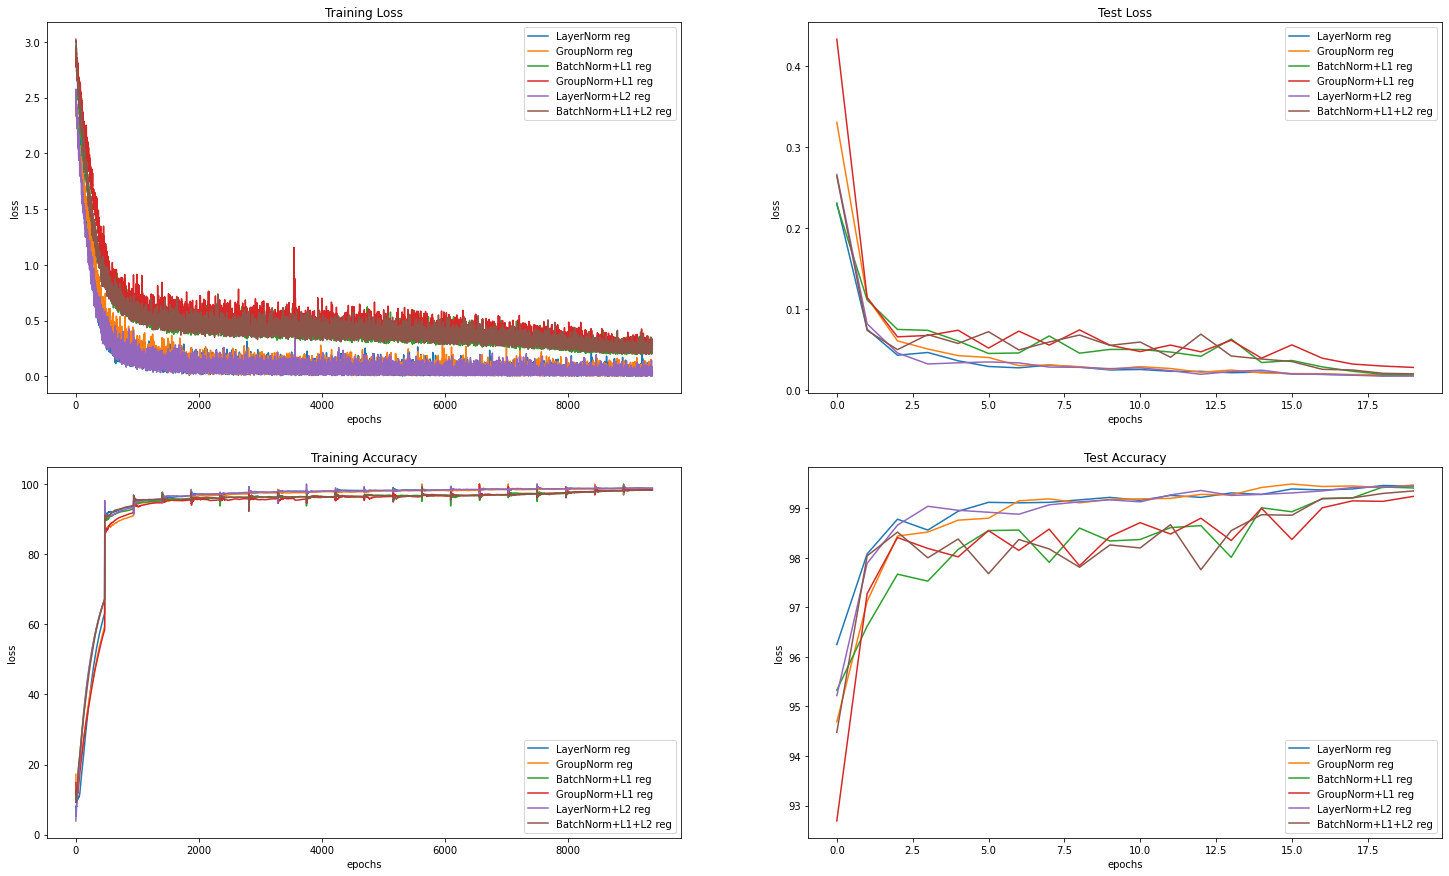

In [ ]:
plot_metrics(exp_metrics)

In [ ]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 

Total wrong predictions are 53


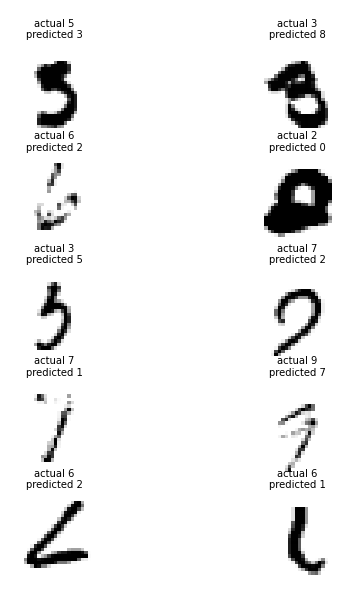

In [ ]:
model = torch.load('./GroupNorm.pt')
model.eval()
wrong_predictions(test_loader,model,device)